# This is how I'll want to use the inversion package on simple problems

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from fatiando import utils
import cPickle as pickle
from inversion import LinearMisfit

In [2]:
class Regression(LinearMisfit):
    def __init__(self, degree):
        # The solver is now independent of the data.
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        
    def predict(self, x, p=None):
        # Make ommiting p option explicit
        # People from workshop said it was strange that it could be ommited even though they didn't code it that way
        if p is None:
            p = self.p_
        return sum(p[i]*x**i for i in reversed(range(self.nparams)))
        
    def jacobian(self, x, p):
        # Last argument is always p
        # Can have multiple args before it
        A = np.empty((x.size, self.nparams))
        for i in reversed(range(self.nparams)):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        """
        Docstrings!
        """
        return super().fit(x, y, **kwargs)
    
    def fmt_estimate(self, p):
        eq = ' + '.join(['{:g}x^{}'.format(p[i], i) for i in reversed(range(self.nparams))])
        return eq

# Test on data

In [3]:
coefs = a, b, c, d = 0.5, 0, 1, 1000
def make_data(coefs, n):
    x = np.linspace(-100, 100, n)
    y = a*x**3 + b*x**2 + c*x + d
    yo = utils.contaminate(y, 0.1, percent=True, seed=0)
    return x, yo
x, yo = make_data(coefs, 100)

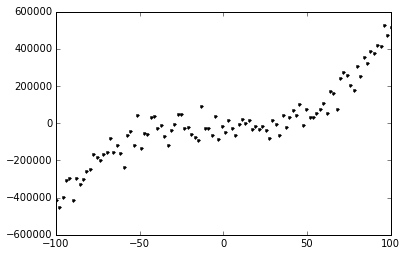

In [4]:
plt.plot(x, yo, '.k')

In [5]:
reg = Regression(3)
reg.fit(x, yo).p_

array([ -2.10677952e+04,  -9.75794938e+01,   6.48924275e+00,
         5.03935080e-01])

In [6]:
reg.fmt_estimate(coefs[::-1])

'0.5x^3 + 0x^2 + 1x^1 + 1000x^0'

In [7]:
reg.estimate_
# Should print the equation

'0.503935x^3 + 6.48924x^2 + -97.5795x^1 + -21067.8x^0'

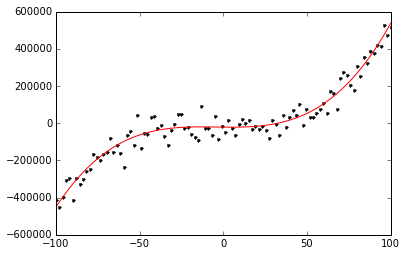

In [8]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

In [9]:
# Caching still works
reg.predict(x) is reg.predict(x)

True

In [10]:
# But the Jacobian is still cached
reg.jacobian(x=x, p=None) is reg.jacobian(x=x, p=None)

True

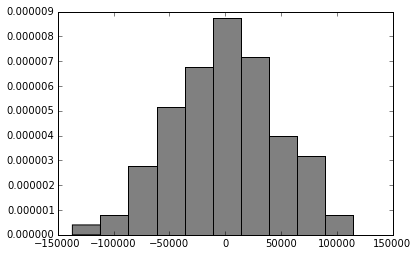

In [11]:
# No more residuals, since reg doesn't store the data
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

In [12]:
# Can be pickled for use in parallel
reg = pickle.loads(pickle.dumps(reg))

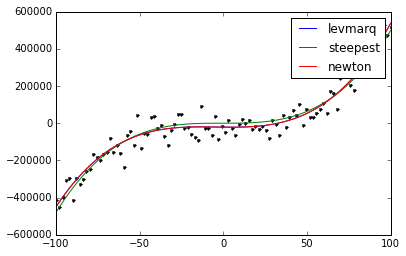

In [13]:
# Config still works
plt.plot(x, yo, '.k')
for meth in ['levmarq', 'steepest', 'newton']:
    reg = Regression(3)
    reg.config(method=meth, initial=np.ones(reg.nparams)).fit(x, yo).estimate_
    plt.plot(x, reg.predict(x), '-', label=meth)
plt.legend()

In [14]:
# Config still works
reg.config(method='acor', bounds=[0, 10000, 0, 10, 0, 1, 0, 10]).fit(x, yo).estimate_

'0.490541x^3 + 1x^2 + 8.3069e-11x^1 + 3.32188e-10x^0'

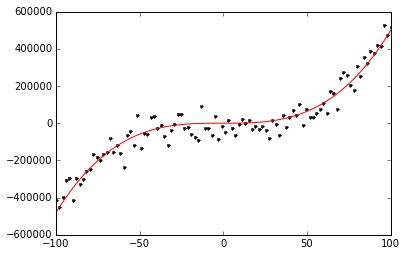

In [15]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Using cross-validation

In [16]:
whole = np.random.permutation(x.size)
divide = int(0.6*x.size)
train, test = whole[:divide], whole[divide:]

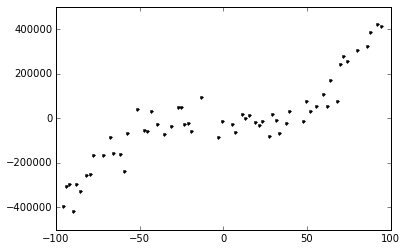

In [17]:
plt.plot(x[train], yo[train], '.k')

In [18]:
degrees = list(range(1, 20))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test])
          for i in degrees]
best = degrees[np.argmin(scores)]
best

3

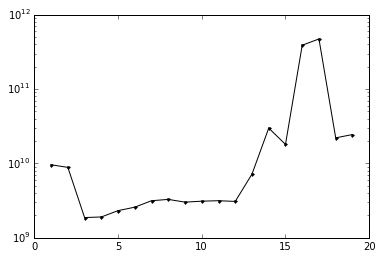

In [19]:
plt.plot(degrees, scores, '.-k')
plt.yscale('log')

In [20]:
reg = Regression(best).fit(x, yo)
reg.estimate_

'0.503935x^3 + 6.48924x^2 + -97.5795x^1 + -21067.8x^0'

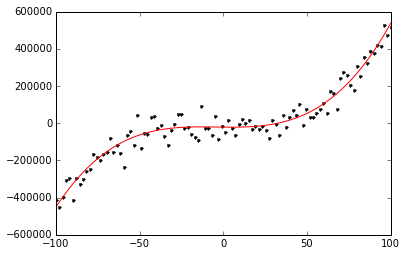

In [21]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Re-weighted

In [22]:
yo2 = np.copy(yo)
yo2[[30, 40, 60, 70]] += 1e6

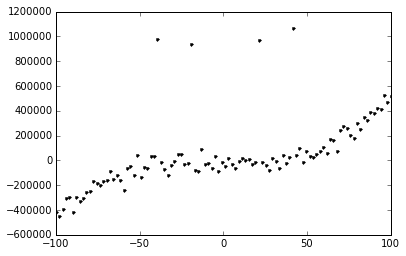

In [23]:
plt.plot(x, yo2, '.k')

In [24]:
reg = Regression(3).fit(x, yo2)
reg.estimate_

'0.498838x^3 + -3.80107x^2 + -54.5019x^1 + 53926.2x^0'

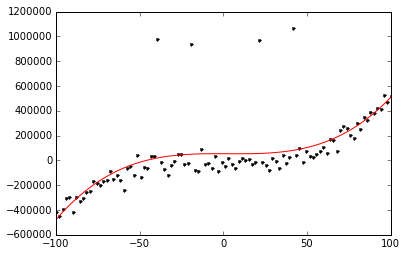

In [25]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

In [26]:
reg2 = Regression(3).fit(x, yo2)
r = np.abs(yo2 - reg2.predict(x))
reg2.fit(x, yo2, weights=1/r).estimate_

'0.520817x^3 + -0.0394088x^2 + -246.42x^1 + 24692.3x^0'

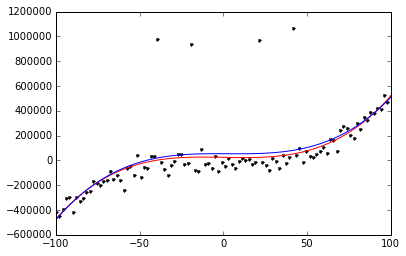

In [27]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

In [28]:
reg3 = Regression(3).fit_reweighted(x, yo2, iterations=100)
reg3.estimate_

'0.491578x^3 + 5.98929x^2 + -57.537x^1 + -21162.4x^0'

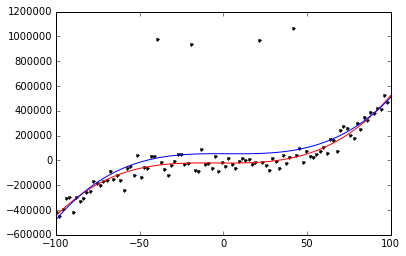

In [29]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg3.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

# Multiple data sets

In [30]:
x2 = np.linspace(110, 200, 200)
y2 = 0.05*(x2 - 50)**3 + 1000
yo2 = utils.contaminate(y2, 0.1, percent=True)

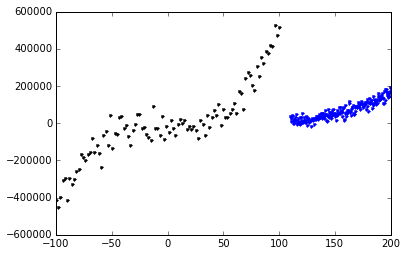

In [31]:
plt.plot(x, yo, '.k')
plt.plot(x2, yo2, '.b')

In [34]:
# If there are many misfits (have fit method), will split the arguments between them.
(Regression(3) + 1e-10*Regression(1)).fit(x, yo, x2, yo2).estimate_

TypeError: unsupported operand type(s) for *: 'float' and 'Regression'

In [ ]:
(1e-10*Regression(3) + Regression(1)).fit(x, yo, x2, yo2).estimate_